In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from functools import partial

import torch
import torch.nn as nn

import sys
sys.path.append("../../")

from baseline.MY_PATHS import *

from baseline.data_creation import wiki_dataset
from baseline.data_creation.preprocess import pad_collate_fn

import baseline.training
from baseline.training import get_train_val_loader, ClassifierLearner

import baseline.model
from baseline.model import FinalModel

import baseline.results_analysis
from baseline.results_analysis import plot_errorbars_by_model, get_mean_std_k

/scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/mz2476/min

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Monolingual (en)

## Load the data

In [4]:
(index_to_word, word_to_index,
     dict_wiki_tensor_dataset,
     weights_matrix_ve, classes) = wiki_dataset.get_monolingual_datasets(
                                                LANGUAGE="english", 
                                                max_num_tokens=1000,
                                                SAVE=True, LOAD=False)

english vocab size is: 817780
Order: dict_keys(['english'])


  0%|          | 0/26764 [00:00<?, ?it/s]

Combined train size: 8921 
Combined val size: 3345


100%|██████████| 3345/3345 [00:00<00:00, 5067.60it/s]
2519370it [03:49, 10979.00it/s]


Total words in vocab: 817780
No. of words from vocab found in embeddings: 598288
Saved /scratch/mz2476/wiki/data/202001_dumps/en_embeddings_matrix_with_idx_to_word.pt
Embeddings matrix shape: torch.Size([817782, 300]), 
Vocab size: 817782


In [5]:
dict_wiki_tensor_dataset["val"] = dict_wiki_tensor_dataset["val_en"]
dict_wiki_tensor_dataset.keys()

dict_keys(['monolingual_train_en', 'multilingual_train_en', 'val_en', 'val'])

In [6]:
dict_wiki_tensor_dataset['multilingual_train_en'][1]

TextData(tokens=tensor([248506, 511995, 248510, 603388, 152379, 788195, 140934, 119704,  10576,
        410789, 215106, 248506,  92660, 215109, 277006, 503897, 110248, 503757,
        603388, 146796, 199755, 675997, 277435, 277006, 788195,  39328, 489037,
        564572, 218821, 516156, 665525, 615497, 515918, 456060, 544746, 112305,
        395740, 137598, 404768, 662928, 321119, 243021, 515918, 497519, 665525,
        810601, 676188, 683500, 248506, 408507, 291099, 683500, 248506, 722596,
        571074, 199553, 515918, 497519, 497519, 812585, 248506, 327210, 473388,
        537788, 701508, 493548, 172258, 147819,  20959, 735413, 206958, 572983,
        599505, 432467, 270475, 324940,   3661, 548235, 240244, 572529, 327671,
        293412, 425949, 248506, 515918, 574971, 152377, 689740, 622962,  10576,
        408507,  10588, 152377, 308430, 176632, 321196, 648138, 297959, 308430,
        176632, 321196, 290922, 408507,  10588, 152377, 255129, 567578, 544944,
        112300, 242330, 

## Model

In [10]:
SAVE_MODEL = False

batch_size = 8
lr = 0.01
num_epochs = 10

options = {
    "VOCAB_SIZE": len(index_to_word),
    "dim_e": weights_matrix_ve.shape[1],
    "pretrained_embeddings": weights_matrix_ve,
    "num_layers": 1,
    "num_classes": len(classes),
    "mid_features": 150,
    "dropout_rate": 0.2,
    "activation": nn.ReLU(),
}
    
result = {
    "optimizer": "Adam", 
    "num_hidden": options["num_layers"],
    "dim_hidden": options["mid_features"],
    "dropout_rate": options["dropout_rate"],
    "learning_rate": lr,
    "num_epochs": num_epochs,
}


print("\n", result)
model_name = "en_" + "_".join([str(key) + "_" + str(value) for key, value in result.items()])

learner = ClassifierLearner(options, model_name, device=device)

TRAIN_SET_NAME = "monolingual_train_en"

val_keys = ["val", "val_en"]
train_loader, dict_val_loader = get_train_val_loader(
    dict_wiki_tensor_dataset[TRAIN_SET_NAME], 
    [dict_wiki_tensor_dataset[key] for key in val_keys], 
    collate_fn=partial(pad_collate_fn, pad_token=word_to_index["<pad>"])
)

dict_val_loader = {
   key : val_loader 
   for key, val_loader in zip(val_keys, dict_val_loader)
}


 {'optimizer': 'Adam', 'num_hidden': 1, 'dim_hidden': 150, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'num_epochs': 10}


In [11]:
learner.set_loaders(train_loader, dict_val_loader)
learner.train_model(num_epochs=10, lr=0.01)

0 epoch
Precision macro: 0.6106, Recall macro: 0.2557, F1 macro: 0.3208 
Precision micro: 0.8555, Recall micro: 0.4928, F1 micro: 0.6254 
1 epoch
Precision macro: 0.7089, Recall macro: 0.3627, F1 macro: 0.4438 
Precision micro: 0.851, Recall micro: 0.5932, F1 micro: 0.6991 
2 epoch
Precision macro: 0.7626, Recall macro: 0.4093, F1 macro: 0.498 
Precision micro: 0.8608, Recall micro: 0.6152, F1 micro: 0.7175 
3 epoch
Precision macro: 0.7843, Recall macro: 0.4418, F1 macro: 0.5381 
Precision micro: 0.8705, Recall micro: 0.6193, F1 micro: 0.7237 
4 epoch
Precision macro: 0.8017, Recall macro: 0.4658, F1 macro: 0.5615 
Precision micro: 0.8718, Recall micro: 0.6382, F1 micro: 0.7369 
5 epoch
Precision macro: 0.8114, Recall macro: 0.5062, F1 macro: 0.5983 
Precision micro: 0.8674, Recall micro: 0.658, F1 micro: 0.7484 
6 epoch
Precision macro: 0.8221, Recall macro: 0.5129, F1 macro: 0.6078 
Precision micro: 0.8643, Recall micro: 0.6721, F1 micro: 0.7561 
7 epoch
Precision macro: 0.8361, Reca

({'precision_macro': 0.81905119950785,
  'recall_macro': 0.539689167695425,
  'f1_macro': 0.6301319986603817,
  'precision_micro': 0.8670085877862596,
  'recall_micro': 0.6843988325016477,
  'f1_micro': 0.764956590370955},
 9)

In [13]:
learner.best_metrics_dict

{'precision_macro': 0.81905119950785,
 'recall_macro': 0.539689167695425,
 'f1_macro': 0.6301319986603817,
 'precision_micro': 0.8670085877862596,
 'recall_micro': 0.6843988325016477,
 'f1_micro': 0.764956590370955}

In [ ]:
batch_size = 8
lr = 0.01
num_epochs = 10

options = {
    "VOCAB_SIZE": len(index_to_word),
    "dim_e": weights_matrix_ve.shape[1],
    "pretrained_embeddings": weights_matrix_ve,
    "num_layers": 1,
    "num_classes": len(classes),
    "mid_features": 150,
    "dropout_rate": 0.2,
    "activation": nn.ReLU(),
}
    
result = {
    "optimizer": "Adam", 
    "num_hidden": options["num_layers"],
    "dim_hidden": options["mid_features"],
    "dropout_rate": options["dropout_rate"],
    "learning_rate": lr,
    "num_epochs": num_epochs,
}



In [1]:
import pandas as pd
from itertools import product
from training import fit_model_given_options

# CONST
NUM_EPOCHS = 35
LEARNING_RATE = 0.3

# CHANGE
LANGUAGE = "english"
LIST_MAX_NUM_TOKENS = [500, 1000, None]
LIST_NUM_LAYERS     = [1, 2, 3]
LIST_MID_FEATURES   = [50, 150, 250]


list_params_names = ["max_num_tokens", "num_layers", "mid_features"]
list_scores_names = ['precision_macro', 'recall_macro', 'f1_macro',
                     'precision_micro',  'recall_micro', 'f1_micro']
results_df = pd.DataFrame(columns=list_params_names+list_scores_names)

# CALCULATED BASE ON PREVIOUS
EXPERIMENT_NAME = f"20200212_{LANGUAGE}_experiment"


for max_num_tokens in LIST_MAX_NUM_TOKENS:
    (index_to_word, word_to_index,
        dict_wiki_tensor_dataset,
        weights_matrix_ve, classes) = wiki_dataset.get_monolingual_datasets(
                                                    LANGUAGE=LANGUAGE, 
                                                    max_num_tokens=max_num_tokens,
                                                    SAVE=True, LOAD=False)

    for num_layers, mid_features in product(LIST_NUM_LAYERS, LIST_MID_FEATURES):
        options["num_layers"]   = num_layers
        options["mid_features"] = mid_features
        
        learner = fit_model_given_options(
            options, dict_wiki_tensor_dataset,
            num_epochs=NUM_EPOCHS, lr=LEARNING_RATE,
            pad_idx=word_to_index["<pad>"], device=device,
            TRAIN_SET_NAME="train")

        # appending scores to df
        list_current_params = [max_num_tokens, num_layers, mid_features]
        list_best_metrics = list(learner.best_metrics_dict.values())
        results_df.loc[results_df.shape[0]] = list_current_params + list_best_metrics

        results_df.to_csv(f"../results/{EXPERIMENT_NAME}.csv")

SyntaxError: invalid syntax (<ipython-input-1-10c6ba477819>, line 30)

# Multilingual

In [3]:
(index_to_word, word_to_index,
     dict_wiki_tensor_dataset,
     weights_matrix_ve, classes) = wiki_dataset.get_mixed_datasets(LANGUAGES_LIST=["english", "russian", "hindi"],
                                                                  SAVE=False, LOAD=True)

english vocab size is: 817780
russian vocab size is: 911153
hindi vocab size is: 462838
Order: dict_keys(['english', 'russian', 'hindi'])


  1%|          | 162/26764 [00:00<00:16, 1606.36it/s]

Combined train size: 26763 
Combined val size: 10035


100%|██████████| 10035/10035 [00:03<00:00, 2585.05it/s]
2519370it [03:29, 12030.90it/s]


Total words in vocab: 817780
No. of words from vocab found in embeddings: 598288
Saved /scratch/mz2476/wiki/data/202001_dumps/en_embeddings_matrix_with_idx_to_word.pt


1888423it [02:41, 11661.07it/s]


Total words in vocab: 911153
No. of words from vocab found in embeddings: 630674
Saved /scratch/mz2476/wiki/data/202001_dumps/ru_embeddings_matrix_with_idx_to_word.pt


158016it [00:13, 11928.96it/s]


Total words in vocab: 462838
No. of words from vocab found in embeddings: 104529
Saved /scratch/mz2476/wiki/data/202001_dumps/hi_embeddings_matrix_with_idx_to_word.pt
Embeddings matrix shape: torch.Size([2191773, 300]), 
Vocab size: 2191773


In [103]:
SAVE_MODEL = False

batch_size = 8
lr = 0.01
num_epochs = 10

options = {
    "VOCAB_SIZE": len(index_to_word),
    "dim_e": weights_matrix_ve.shape[1],
    "pretrained_embeddings": weights_matrix_ve,
    "num_layers": 2,
    "num_classes": len(classes),
    "mid_features": 150,
    "dropout_rate": 0.2,
    "activation": nn.ReLU(),
}
    
result = {
    "optimizer": "Adam", 
    "num_hidden": options["num_layers"],
    "dim_hidden": options["mid_features"],
    "dropout_rate": options["dropout_rate"],
    "learning_rate": lr,
    "num_epochs": num_epochs
}


print("\n", result)
model_name = "mixed_en_hi_ru_" + "_".join([str(key) + "_" + str(value) for key, value in result.items()])

learner = ClassifierLearner(options, model_name, device=device)

TRAIN_SET_NAME = "train_ru_hi"

val_keys = ["val_en", "val_ru", "val_hi", "val"]
train_loader, dict_val_loader = get_train_val_loader(
    dict_wiki_tensor_dataset[TRAIN_SET_NAME], 
    [dict_wiki_tensor_dataset[key] for key in val_keys], 
    collate_fn=partial(pad_collate_fn, pad_token=word_to_index["<pad>"])
)


 {'optimizer': 'Adam', 'num_hidden': 2, 'dim_hidden': 150, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'num_epochs': 10}


In [104]:
dict_val_loader = {
   key : val_loader 
   for key, val_loader in zip(val_keys, dict_val_loader)
}

In [105]:
learner.set_loaders(train_loader, dict_val_loader)

In [106]:
learner.train_model(num_epochs=10, lr=0.01)

0 epoch


/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision macro: 0.478, Recall macro: 0.308, F1 macro: 0.338 
Precision micro: 0.6999, Recall micro: 0.5129, F1 micro: 0.592 
1 epoch
Precision macro: 0.5606, Recall macro: 0.3561, F1 macro: 0.4034 
Precision micro: 0.7577, Recall micro: 0.5422, F1 micro: 0.6321 
2 epoch
Precision macro: 0.5981, Recall macro: 0.3765, F1 macro: 0.4323 
Precision micro: 0.78, Recall micro: 0.5484, F1 micro: 0.644 
3 epoch
Precision macro: 0.6154, Recall macro: 0.3955, F1 macro: 0.4528 
Precision micro: 0.7778, Recall micro: 0.5398, F1 micro: 0.6373 
4 epoch
Precision macro: 0.6637, Recall macro: 0.3488, F1 macro: 0.426 
Precision micro: 0.8099, Recall micro: 0.5097, F1 micro: 0.6257 
5 epoch
Precision macro: 0.6996, Recall macro: 0.3894, F1 macro: 0.4702 
Precision micro: 0.7945, Recall micro: 0.5243, F1 micro: 0.6318 
6 epoch
Precision macro: 0.6558, Recall macro: 0.3706, F1 macro: 0.4479 
Precision micro: 0.7915, Recall micro: 0.5234, F1 micro: 0.6301 
7 epoch
Precision macro: 0.6834, Recall macro: 0.3

({'precision_macro': 0.5981279524194624,
  'recall_macro': 0.3765000431513384,
  'f1_macro': 0.4323283941173918,
  'precision_micro': 0.7799862919808088,
  'recall_micro': 0.548433734939759,
  'f1_micro': 0.644029428409734},
 2)

In [12]:
# model_to_mean_std = {}

In [107]:
model_name = "ru_hi"
metric_name='f1_micro'

model_to_mean_std[model_name] = get_mean_std_k(
    learner, num_splits=5, dict_wiki_tensor_dataset=dict_wiki_tensor_dataset,
    metric_name=metric_name)

path_to_scores = Path(f"results/{metric_name}_scores/")
path_to_scores.mkdir(exist_ok=True)

torch.save({model_name : model_to_mean_std[model_name]},
           path_to_scores/f"{model_name}_mean_std.pt")

/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [108]:
model_to_mean_std

{'en_ru_hi': (array([0.72578073, 0.73661407, 0.72184931, 0.71880635]),
  array([0.01138429, 0.01295924, 0.00999198, 0.01529219])),
 'en_10000': (array([0.56765543, 0.74780998, 0.51652677, 0.41886   ]),
  array([0.01769305, 0.00759178, 0.01055212, 0.02637208])),
 'ru_10000': (array([0.50379083, 0.28351139, 0.74216949, 0.38999469]),
  array([0.01480177, 0.01275749, 0.01128729, 0.01290086])),
 'hi_10000': (array([0.49762526, 0.2637681 , 0.44155477, 0.7321612 ]),
  array([0.01204092, 0.02172915, 0.02064882, 0.00725539])),
 'ru_hi': (array([0.60975416, 0.32264033, 0.72024224, 0.70657882]),
  array([0.00287078, 0.02289315, 0.01780929, 0.01101969]))}

In [76]:
# for model_name in model_to_mean_std.keys():
#     torch.save({model_name : model_to_mean_std[model_name]}, f"results/f1_micro_scores/{model_name}_mean_std.pt")

In [117]:
def create_plot(files_list, model_names, colors_m="kbrg"):
    # Load
    model_to_mean_std = {}
    # files_list = path_to_scores.iterdir()

    [model_to_mean_std.update(torch.load(fname)) for fname in files_list]

    mean_mk = np.array([mean_std[0] for mean_std in model_to_mean_std.values()])
    std_mk  = np.array([mean_std[1] for mean_std in model_to_mean_std.values()])

    axis = plot_errorbars_by_model(np.array(mean_mk), np.array(std_mk), labels_m=model_names, colors_m=colors_m,)
    axis.set_xlabel("Subset of validation articles")
    axis.set_ylabel("Micro F1 score")
    axis.legend()
    return axis

In [40]:
# ! rm -r results/f1_micro_scores/.ipynb_checkpoints

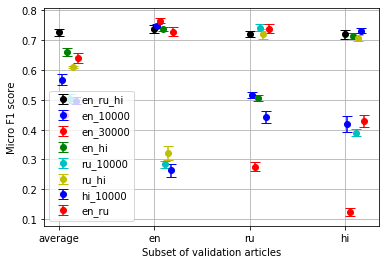

In [116]:
path_to_scores = Path(f"results/{metric_name}_scores/")
files_list = list(path_to_scores.iterdir())
model_to_mean_std = {}

[model_to_mean_std.update(torch.load(fname)) for fname in files_list]

create_plot(files_list, model_to_mean_std.keys(), "kbrgcybr")

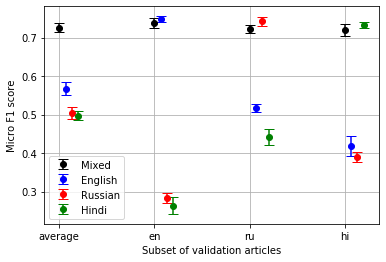

In [118]:
files_list = [
    'results/f1_micro_scores/en_ru_hi_mean_std.pt',
    'results/f1_micro_scores/en_10000_mean_std.pt',
    'results/f1_micro_scores/ru_10000_mean_std.pt',
    'results/f1_micro_scores/hi_10000_mean_std.pt',
]
model_names = [
    "Mixed",
    "English",
    "Russian",
    "Hindi",
]

create_plot(files_list, model_names, "kbrg")

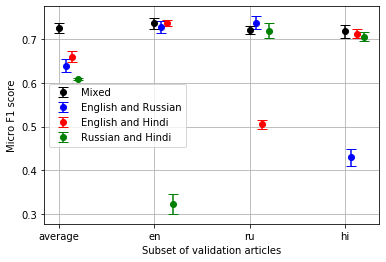

In [119]:
files_list = [
    'results/f1_micro_scores/en_ru_hi_mean_std.pt',
    'results/f1_micro_scores/en_ru_mean_std.pt',
    'results/f1_micro_scores/en_hi_mean_std.pt',
    'results/f1_micro_scores/ru_hi_mean_std.pt',
]
model_names = [
    "Mixed",
    "English and Russian",
    "English and Hindi",
    "Russian and Hindi",
]

create_plot(files_list, model_names, "kbrg")

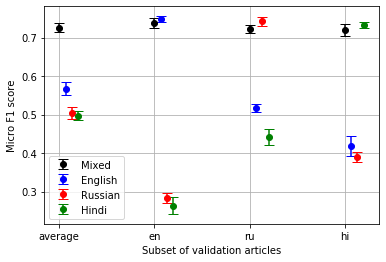

/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro
0,0.601943,0.474778,0.501424,0.806897,0.659155,0.725581
1,0.581520,0.475961,0.501708,0.798276,0.685926,0.737849
2,0.601665,0.457821,0.497679,0.795041,0.668056,0.726038


In [69]:
[np.arange(start, 100, num_splits) for start in range(num_splits)]

[array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
        86, 91, 96]),
 array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82,
        87, 92, 97]),
 array([ 3,  8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83,
        88, 93, 98]),
 array([ 4,  9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84,
        89, 94, 99])]

In [64]:
indices = np.arange(500)
indices = np.arange(500, 1000)

dict_of_metrics = learner.get_test_metrics(
    data.Subset(learner.val_loader.dataset, indices), device=learner.device)

import pandas as pd

pd.DataFrame([dict_of_metrics, dict_of_metrics])

/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro
0,0.651972,0.482795,0.534985,0.798883,0.680304,0.734841
1,0.651972,0.482795,0.534985,0.798883,0.680304,0.734841


In [ ]:
# train the model
model_name = "mixed_en_hi_ru_" + "_".join([str(key) + "_" + str(value) for key, value in result.items()])
print(model_name)
metrics_dict = train_model(train_loader, val_loader, model, criterion, optimizer, options, device,
                num_epochs=10, model_name="model", save_model=False)
result.update(metrics_dict)

In [8]:
optimizer.param_groups[0]["lr"]

0.01

In [120]:
# loaders = create_data_loaders_for_model(wiki_loaders["train"], wiki_loaders["val"])
# # create dataloader
# wiki_loaders = {}


# for split, wiki_dataset in dict_wiki_tensor_dataset.items():
#     wiki_loaders[split] = DataLoader(
#         wiki_dataset, 
#         batch_size=batch_size, 
#         shuffle=True, 
#         collate_fn=partial(pad_collate_fn, word_to_index=word_to_index)
#     )


# train_model(
#     wiki_loaders, model, criterion, optimizer, options=options, num_epochs=num_epochs, 
#     model_name=model_name, save_model=SAVE_MODEL
# )

# results_df = results_df.append(result, ignore_index=True)
#     results_df.to_csv("results/results_tuning_2_3_layers_maxlen_500.csv"

## Combine logits from NLP and GraphSAGE

### NLP

In [124]:
from MY_PATHS import *

In [125]:
# Load train/val/test QIDs
wiki_df_train = torch.load(f"{PATH_TO_DATA_FOR_MODEL_FOLDER}df_wiki_monolingual_train_30000_en.pt")
wiki_df_val   = torch.load(f"{PATH_TO_DATA_FOR_MODEL_FOLDER}df_wiki_valid_1000_en.pt")
wiki_df_test  = torch.load(f"{PATH_TO_DATA_FOR_MODEL_FOLDER}df_wiki_test_en.pt")


In [ ]:
SAVE_MODEL = False

batch_size = 8
lr = 0.01
num_epochs = 10

options = {
    "VOCAB_SIZE": len(index_to_word),
    "dim_e": weights_matrix_ve.shape[1],
    "pretrained_embeddings": weights_matrix_ve,
    "num_layers": 2,
    "num_classes": len(classes),
    "mid_features": 150,
    "dropout_rate": 0.2,
    "activation": nn.ReLU(),
}
    
result = {
    "optimizer": "Adam", 
    "num_hidden": options["num_layers"],
    "dim_hidden": options["mid_features"],
    "dropout_rate": options["dropout_rate"],
    "learning_rate": lr,
    "num_epochs": num_epochs
}


print("\n", result)
model_name = "mixed_en_hi_ru_" + "_".join([str(key) + "_" + str(value) for key, value in result.items()])

learner = ClassifierLearner(options, model_name, device=device)

TRAIN_SET_NAME = "train_ru_hi"

val_keys = ["val_en", "val_ru", "val_hi", "val"]
train_loader, dict_val_loader = get_train_val_loader(
    dict_wiki_tensor_dataset[TRAIN_SET_NAME], 
    [dict_wiki_tensor_dataset[key] for key in val_keys], 
    collate_fn=partial(pad_collate_fn, pad_token=word_to_index["<pad>"])
)